
# IFCD104 – Tema 2: FFNN (MLP) paso a paso en Python

Este cuaderno muestra, de forma **docente y progresiva**, cómo entrenar una **red neuronal feedforward (FFNN)** usando `scikit-learn` (`MLPClassifier`) sobre el dataset **Breast Cancer** (binario).  
Incluye **preprocesado**, **entrenamiento**, **evaluación**, **curva de pérdida**, **matriz de confusión**, **ROC-AUC**, **visualización en 2D (PCA)** e **inspección de pesos**.  



## Objetivos del cuaderno
1. Cargar y preparar los datos (entrenamiento/validación/test + escalado).  
2. Definir y entrenar una **FFNN (MLP)**.  
3. Evaluar el modelo con **métricas clásicas**.  
4. Visualizar la **curva de pérdida**, la **matriz de confusión** y la **ROC**.  
5. Explorar la **estructura interna** (pesos y sesgos).  
6. Ver la **frontera de decisión** en 2D con **PCA** (visualización didáctica).


In [1]:
%pip install numpy matplotlib scikit-learn

   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.7 MB 6.7 MB/s eta 0:00:02
   --------- ------------------------------ 2.1/8.7 MB 6.2 MB/s eta 0:00:02
   -------------- ------------------------- 3.1/8.7 MB 5.9 MB/s eta 0:00:01
   -------------------- ------------------- 4.5/8.7 MB 5.8 MB/s eta 0:00:01
   ------------------------- -------------- 5.5/8.7 MB 5.6 MB/s eta 0:00:01
   ------------------------------ --------- 6.6/8.7 MB 5.5 MB/s eta 0:00:01
   --------------------------------- ------ 7.3/8.7 MB 5.3 MB/s eta 0:00:01
   -------------------------------------- - 8.4/8.7 MB 5.3 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 5.0 MB/s  0:00:01

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- ----

In [2]:

# Importaciones principales
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, auc, RocCurveDisplay
)
from sklearn.decomposition import PCA



## 1) Carga de datos y división en conjuntos
Usamos `load_breast_cancer()` (binario: **benigno** vs **maligno**).  
Separamos en **train / validación / test** para imitar un flujo real de trabajo.


In [4]:

# Carga del dataset
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names
target_names = data.target_names

# División: primero train+temp y test
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# De train_temp sacamos train y validación
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, test_size=0.2, random_state=42, stratify=y_train_temp
)

print("Tamaños -> Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Tamaños -> Train: (364, 30) Val: (91, 30) Test: (114, 30)



## 2) Pipeline de preprocesado + MLP
- **Estandarización** (`StandardScaler`) para que todas las variables estén comparables.  
- **MLPClassifier** con arquitectura (16, 8), activación ReLU y **Adam**.


In [6]:

mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(32, 16),
                          activation='relu',
                          solver='adam',
                          learning_rate_init=0.001,
                          max_iter=500,
                          early_stopping=False,
                          random_state=42))
])


mlp_pipeline.fit(X_train, y_train)

# Predicciones
y_tr_pred = mlp_pipeline.predict(X_train)
y_val_pred = mlp_pipeline.predict(X_val)
y_te_pred = mlp_pipeline.predict(X_test)

print("Accuracy - Train:", accuracy_score(y_train, y_tr_pred))
print("Accuracy - Val:  ", accuracy_score(y_val, y_val_pred))
print("Accuracy - Test: ", accuracy_score(y_test, y_te_pred))


Accuracy - Train: 1.0
Accuracy - Val:   0.967032967032967
Accuracy - Test:  0.956140350877193



## 3) Informe de clasificación (precisión, recall, F1)


In [7]:

print("=== VALIDACIÓN ===")
print(classification_report(y_val, y_val_pred, target_names=target_names))

print("\n=== TEST ===")
print(classification_report(y_test, y_te_pred, target_names=target_names))


=== VALIDACIÓN ===
              precision    recall  f1-score   support

   malignant       0.94      0.97      0.96        34
      benign       0.98      0.96      0.97        57

    accuracy                           0.97        91
   macro avg       0.96      0.97      0.96        91
weighted avg       0.97      0.97      0.97        91


=== TEST ===
              precision    recall  f1-score   support

   malignant       0.91      0.98      0.94        42
      benign       0.99      0.94      0.96        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114




## 4) Curva de pérdida (entrenamiento)
Mostramos cómo disminuye la **función de pérdida** a lo largo de las iteraciones.


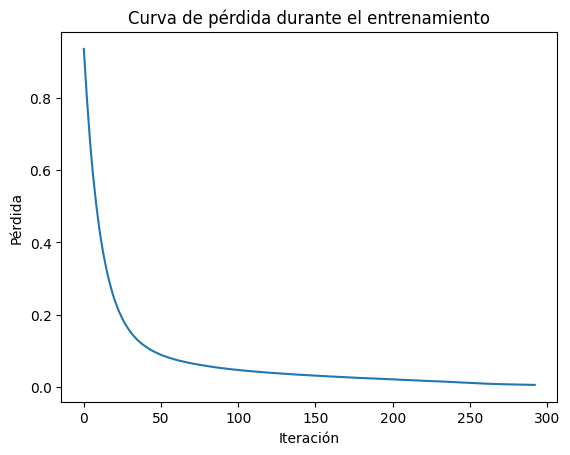

In [8]:

# Extraemos el estimador entrenado (el último paso del pipeline)
mlp_est = mlp_pipeline.named_steps['mlp']

plt.figure()
plt.plot(mlp_est.loss_curve_)
plt.title("Curva de pérdida durante el entrenamiento")
plt.xlabel("Iteración")
plt.ylabel("Pérdida")
plt.show()



## 5) Matriz de confusión (conjunto de test)


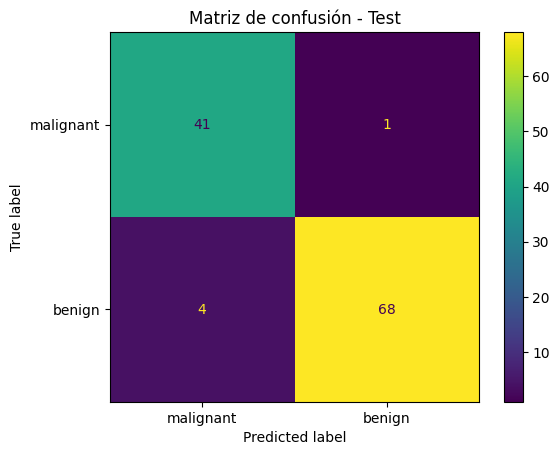

In [9]:

cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(values_format='d')
plt.title("Matriz de confusión - Test")
plt.show()



## 6) Curva ROC y AUC (conjunto de test)


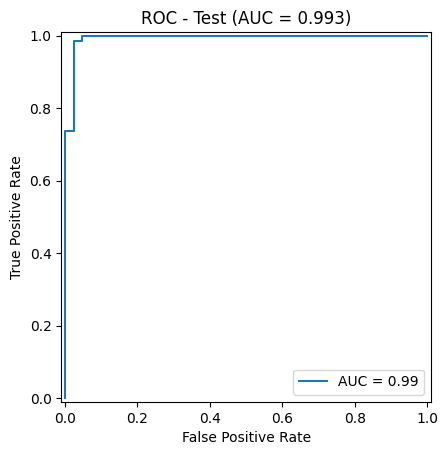

In [17]:

# Para ROC necesitamos probabilidades
y_te_proba = mlp_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_te_proba)
roc_auc = auc(fpr, tpr)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title(f"ROC - Test (AUC = {roc_auc:.3f})")
plt.show()



## 7) Inspección de la estructura interna (pesos y sesgos)
`MLPClassifier` guarda los pesos en `coefs_` y los sesgos en `intercepts_`.


In [13]:

coefs = mlp_est.coefs_
intercepts = mlp_est.intercepts_

for i, (w, b) in enumerate(zip(coefs, intercepts), start=1):
    print(f"Capa {i}: pesos {w.shape}, sesgos {b.shape}")
    
# Mostramos un pequeño resumen (primeras filas/columnas) de la primera matriz de pesos
print("\nVista parcial de la primera matriz de pesos (primeras 5 filas, 5 columnas):")
print(np.round(coefs[0][:5, :5], 4))


Capa 1: pesos (30, 32), sesgos (32,)
Capa 2: pesos (32, 16), sesgos (16,)
Capa 3: pesos (16, 1), sesgos (1,)

Vista parcial de la primera matriz de pesos (primeras 5 filas, 5 columnas):
[[-0.0884  0.3495  0.1792 -0.0113 -0.1775]
 [-0.4483  0.3932  0.3016  0.3057 -0.0845]
 [-0.146   0.0999 -0.1909  0.1208 -0.2286]
 [-0.0224  0.0273 -0.261  -0.326  -0.2544]
 [-0.3249  0.1924 -0.0424 -0.2726 -0.215 ]]



## 8) Visualización didáctica en 2D con PCA
Reducimos a 2 componentes con **PCA** y entrenamos otro MLP sobre ese espacio para **dibujar la frontera de decisión**.  
> *Nota*: Es una visualización pedagógica, no un requisito para el mejor rendimiento.


c:\Users\Alumno\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


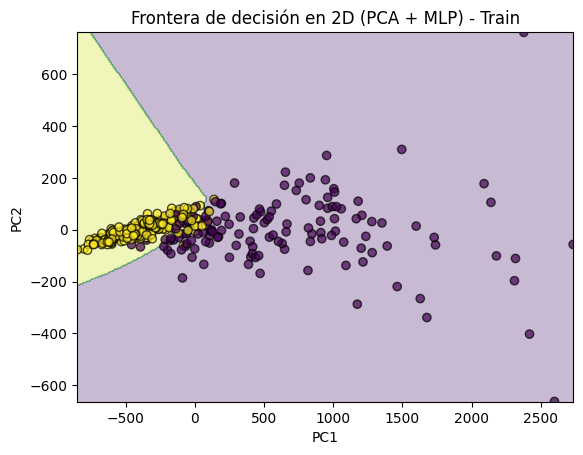

In [15]:

# PCA a 2D sobre train (y aplicamos al resto)
pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train)
X_val_2d   = pca.transform(X_val)
X_test_2d  = pca.transform(X_test)

# Entrenamos un MLP sobre el espacio 2D
mlp_2d = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(8,),
                          activation='relu',
                          solver='adam',
                          random_state=42,
                          max_iter=300))
])
mlp_2d.fit(X_train_2d, y_train)

# Malla para la frontera de decisión
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
Z = mlp_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, edgecolor='k', alpha=0.7)
plt.title("Frontera de decisión en 2D (PCA + MLP) - Train")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



## 9) Experimentación rápida
Modifica los hiperparámetros (`hidden_layer_sizes`, `max_iter`, `activation`, etc.) y **vuelve a ejecutar** para comparar.


In [16]:

# Ejemplo: cambia la arquitectura o prueba otras funciones de activación
mlp_try = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(32, 16, 8),
                          activation='relu',   # prueba 'tanh' o 'logistic'
                          solver='adam',
                          random_state=0,
                          max_iter=300))
])
mlp_try.fit(X_train, y_train)

y_try = mlp_try.predict(X_val)
print("Accuracy de validación con la nueva arquitectura:", accuracy_score(y_val, y_try))


Accuracy de validación con la nueva arquitectura: 0.9560439560439561



## Conclusiones
- Una **FFNN (MLP)** requiere **escalado** para entrenar de forma estable.  
- Es adecuada para **tabulares** en clasificación/regresión.  
- Las curvas de pérdida y las métricas ayudan a **diagnosticar** el aprendizaje.  
- La inspección de `coefs_`/`intercepts_` ofrece una visión básica de la **estructura interna**.  
